In [102]:
import os
import re
import time
import logging
import asyncio
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import mss
import numpy as np
import pydirectinput
import pyautogui
from torch.distributions import Categorical
from mcrcon import MCRcon
from concurrent.futures import ThreadPoolExecutor

In [103]:
# 配置日誌記錄
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [104]:
# 截圖工具 (使用 mss 截取螢幕)
class ScreenCapture:
    def __init__(self, monitor=None):
        self.sct = mss.mss()  # 初始化 mss
        self.monitor = monitor or self.sct.monitors[1]  # 預設使用主螢幕

    def capture(self):
        # 截取螢幕畫面
        img = self.sct.grab(self.monitor)
        img_np = np.array(img)  # 轉換為 numpy 陣列
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)  # 轉換為灰度圖
        img_resized = cv2.resize(img_gray, (84, 84))  # 調整大小為 84x84
        img_tensor = torch.FloatTensor(img_resized).unsqueeze(0).unsqueeze(0).to(device) # 轉為張量並移動到設備上
        return img_tensor

In [105]:
# Actor-Critic 網路
class ActorCriticCNN(nn.Module):
    def __init__(self, action_dim, hidden_dim=256):
        super(ActorCriticCNN, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), 
            nn.ReLU()  
        ).to(self.device)
        self.fc_actor = self._init_fc_layer(hidden_dim, action_dim)
        self.fc_critic = self._init_fc_layer(hidden_dim, 1)

    def _init_fc_layer(self, hidden_dim, output_dim):
        return nn.Sequential(
            nn.Linear(64 * 7 * 7, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1) if output_dim > 1 else nn.Identity()
        ).to(self.device)

    def forward(self, x):
        x = x.to(self.device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return x

    def get_action(self, state):
        x = self.forward(state)
        probs = self.fc_actor(x)
        dist = Categorical(probs)
        action = dist.sample()
        return action, dist.log_prob(action), dist.entropy().mean()

    def evaluate_actions(self, state, action):
        x = self.forward(state)
        probs = self.fc_actor(x)
        dist = Categorical(probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy().mean()
        state_value = self.fc_critic(x)
        return action_logprobs, state_value, dist_entropy

In [106]:
# Memory 類來儲存狀態、動作等
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.logprobs.clear()
        self.rewards.clear()
        self.is_terminals.clear()

    def store(self, state, action, logprob, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.rewards.append(reward)
        self.is_terminals.append(done)

    def compute_returns(self, gamma, device):
        returns = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.rewards), reversed(self.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + gamma * discounted_reward
            returns.insert(0, discounted_reward)
        return torch.tensor(returns, dtype=torch.float32).to(device)



In [107]:

# PPO 演算法實現
class PPO:
    def __init__(self, action_dim, lr=0.0003, gamma=0.99, eps_clip=0.2, K_epochs=4):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy = ActorCriticCNN(action_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = ActorCriticCNN(action_dim).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.MseLoss = nn.MSELoss()

    def update(self, memory):
        old_states = torch.stack(memory.states).to(self.device).detach()
        old_actions = torch.stack(memory.actions).to(self.device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(self.device).detach()

        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.policy.evaluate_actions(old_states, old_actions)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = memory.compute_returns(self.gamma, self.device) - state_values.detach()

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, memory.compute_returns(self.gamma, self.device)) - 0.01 * dist_entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)  # 梯度裁剪，防止梯度爆炸
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())


In [108]:

def perform_action(action):
    actions = ["w", "a", "s", "d", "space","shift"]
    
    if action < len(actions):
        # 單一按鍵動作
        pydirectinput.press(actions[action])
    
    elif action == 6:
        # 向右移動滑鼠 
        pyautogui.move(350, 0)
        
    elif action == 7:
        # 向下移動滑鼠
        pyautogui.move(0, 350)
        
    elif action == 8:
        # 向左移動滑鼠
        pyautogui.move(-350, 0)
        
    elif action == 9:
        # 向上移動滑鼠
        pyautogui.move(0, -350)
    
    elif action == 10:
        pydirectinput.keyDown('g')
        pydirectinput.keyDown('w')
        pydirectinput.keyUp('g')
        pydirectinput.press('space')
        pydirectinput.keyUp('w')

    elif action == 11:

        pydirectinput.keyDown('shift')
        pydirectinput.keyDown('s')
        time.sleep(0.5)
        pydirectinput.keyUp('s')
        time.sleep(0.1)
        pydirectinput.keyUp('shift')


    elif action == 12:

        pydirectinput.keyDown('shift')
        pydirectinput.keyDown('w')
        time.sleep(0.5)
        pydirectinput.keyUp('w')
        time.sleep(0.1)
        pydirectinput.keyUp('shift')




In [109]:
# 儲存模型函數
def save_model(policy, filename="ppo_model.pth"):
    torch.save(policy.state_dict(), filename)
    logger.info(f"模型已保存至 {filename}")

In [110]:
# 獲取遊戲狀態的函數
SERVER_IP = os.environ.get("MINECRAFT_SERVER_IP", "25.10.63.224")
RCON_PASSWORD = os.environ.get("MINECRAFT_RCON_PASSWORD", "mySuperSecretPassword123")
RCON_PORT = int(os.environ.get("MINECRAFT_RCON_PORT", "25575"))
def get_game_state():
    try:
        with MCRcon(SERVER_IP, RCON_PASSWORD, port=RCON_PORT) as mcr:
            response_value = mcr.command("/scoreboard players get Suhan_0801 value")
            response_death = mcr.command("/scoreboard players get Suhan_0801 death")
            value = re.search(r'has (\d+)',response_value)
            death = re.search(r'has (\d+)', response_death)
            value = int(value.group(1))
            death = int(death.group(1))
            return value, death
    except Exception as e:
        logger.error(f"Error getting game state: {e}")
        return None, None

0 0
0 0
0 0
0 0
0 0
0 0
0 0


INFO:__main__:Episode 1/10, Total Reward: -10.7


1 0


INFO:__main__:Episode 2/10, Total Reward: -10


1 0


INFO:__main__:Episode 3/10, Total Reward: -10


1 0


INFO:__main__:Episode 4/10, Total Reward: -10


1 0


INFO:__main__:Episode 5/10, Total Reward: -10


1 0


INFO:__main__:Episode 6/10, Total Reward: -10
INFO:__main__:Episode 7/10, Total Reward: -10


1 0
1 0


INFO:__main__:Episode 8/10, Total Reward: -10


2 0


INFO:__main__:Episode 9/10, Total Reward: -10


2 0


INFO:__main__:Episode 10/10, Total Reward: -10
INFO:__main__:模型已保存至 ppo_model.pth


2 0


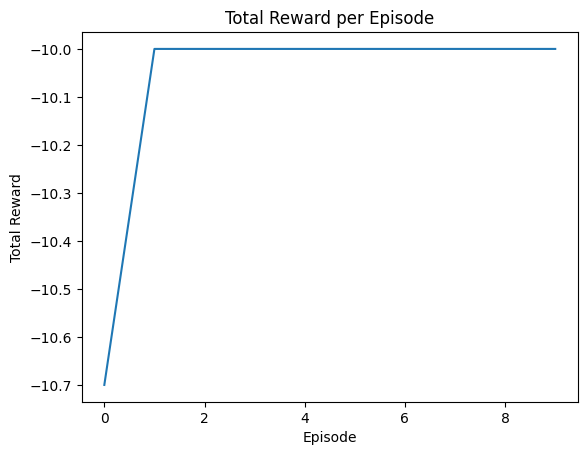

In [111]:

time.sleep(6)

# 主要超參數設置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
action_dim = 13
memory = Memory()
ppo = PPO(action_dim)
episodes = 10
max_timesteps = 500
gamma = 0.99
update_timestep = 2000
timestep = 0
rewards_per_episode = []

# 訓練結束後儲存模型

# 開始訓練迴圈
for episode in range(episodes):
    total_reward = 0
    previous_value, previous_death = 0, 0
    done = False

    for t in range(max_timesteps):
        timestep += 1
        screen = ScreenCapture().capture()
        action, logprob, _ = ppo.policy_old.get_action(screen)

        perform_action(action.item())  # 執行動作

        value, death = get_game_state()
        if previous_value is not None and previous_death is not None:
            if value > previous_value:
                reward = 1
            elif death > previous_death:
                reward = -10
                done = True
            else:
                reward = -0.1
        else:
            reward = 0

        previous_value, previous_death = value, death
        print(death,previous_death)
        memory.store(screen, action, logprob, reward, done)
        total_reward += reward

        if timestep % update_timestep == 0:
            memory.returns = memory.compute_returns(gamma, device)
            ppo.update(memory)
            memory.clear()
            timestep = 0

        if done:
            break
 
    rewards_per_episode.append(total_reward)
    logger.info(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# 繪製獎勵圖表

save_model(ppo.policy)

plt.plot(rewards_per_episode)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

RCON 連接測試 打勾

了解異步概念  打勾

RuntimeWarning 沒有正確等待 打勾

滑鼠控制問題(會跑到左上角)  打勾

重寫獎勵函數 


